# Overview

In this notebook, we simply plot the map Australia and look at how different organisms are spread and/or found in Australia.

In [1]:
%%capture

# Installing the required libraries:
!pip install matplotlib pandas scikit-learn  
!pip install pyarrow tensorflow geopandas
!pip install google-cloud-bigquery google-cloud-bigquery-storage

In [2]:
# Python Builtin Libraries

# Third Party Libraries
import numpy as np
import geopandas
from google.cloud import bigquery
import matplotlib.pyplot as plt

# Configurations
%matplotlib inline

### Configurations

Let's make sure we enter the name of our GCP project in the next cell.

In [3]:
# ENTER THE GCP PROJECT HERE
gcp_project = "gcp-public-data-contributors" # "YOUR-GCP-PROJECT"
print(f"gcp_project is set to {gcp_project}")

gcp_project is set to gcp-public-data-contributors


Also, let's select the country. In this notebook, we have selected Australia. For a more accurate mapping, we also select the region that contains Australia. This helps us exclude the entires with the country code `AU`, but with latitudes and longitudes that are not in this region.

In [4]:
# Select Coutry:
country_name = 'Australia'
country_code = 'AU'
TOP_LEFT = (-11, 110)
BOTTOM_RIGHT = (-40, 157)

### Authentication
The following cell authenticates the user through [Colab](https://colab.sandbox.google.com/). If you intend to run this notebook elsewhere, you will need to change the authentication code in the next cell accordingly.   |

In [5]:
from google.colab import auth

print("Authenticating in Colab")
auth.authenticate_user()
print("Authenticated")

Authenticating in Colab
Authenticated


## Data Preparation

### Query the Data

In [6]:
query = f"""
SELECT kingdom, decimallatitude, decimallongitude
FROM
  `bigquery-public-data.gbif.occurrences` TABLESAMPLE SYSTEM (1 PERCENT)
WHERE
  decimallatitude IS NOT NULL
  AND decimallongitude IS NOT NULL
  AND decimallatitude BETWEEN {BOTTOM_RIGHT[0]} AND {TOP_LEFT[0]}
  AND decimallongitude BETWEEN {TOP_LEFT[1]} AND {BOTTOM_RIGHT[1]}
  AND countrycode = '{country_code}';
"""

In [7]:
bqclient = bigquery.Client(project=gcp_project)
dataframe = bqclient.query(query).result().to_dataframe()

### Check the Dataframe



In [8]:
print(dataframe.shape)
dataframe.head()

(650990, 3)


,kingdom,decimallatitude,decimallongitude
0,Fungi,-17.8200,145.550
1,Fungi,-35.5000,149.520
2,Fungi,-28.2300,152.330
3,Chromista,-34.9667,118.183
4,Chromista,-37.1667,139.750


### View the Map

In [9]:
# Using geopandas to extract the map of Australia:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
country = world.loc[world['name'] == country_name]

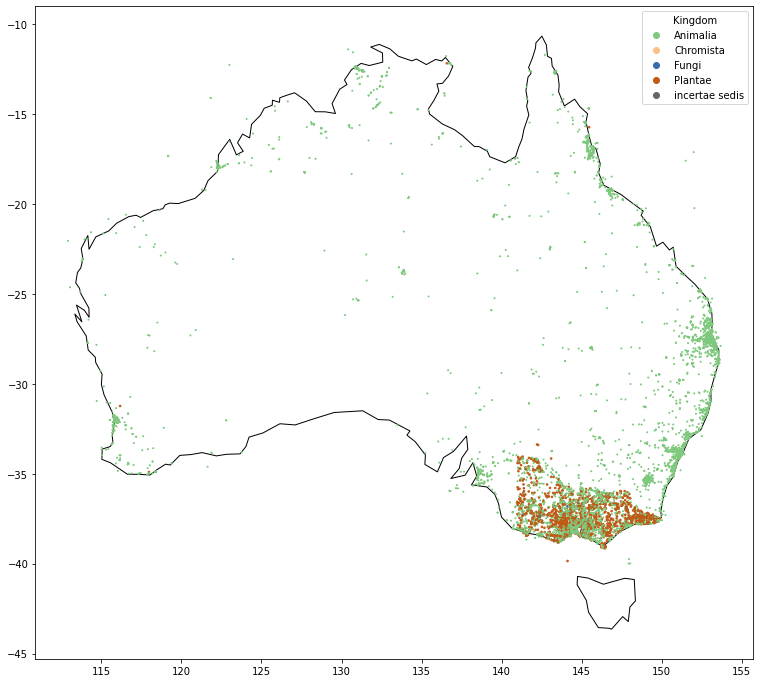

In [10]:
# Using a subset of the entire dataframe to create the map:
subdataframe = dataframe.sample(n=10000)

labels, indices = np.unique(subdataframe['kingdom'].values, return_inverse=True)

ax = country['geometry'].plot(color='white', edgecolor='black', figsize=(18, 12))
scatter = ax.scatter(x=subdataframe['decimallongitude'],
                     y=subdataframe['decimallatitude'],
                     s=indices / 2.0 + 1.0,
                     c=indices,
                     cmap='Accent')
ax.legend(scatter.legend_elements()[0], labels, title='Kingdom', loc=1)
plt.show();